# Classifying Microscopic Histopathology Images with Pytorch
This project classifies images as cancerous or normal, using computer vision and CNN via pytorch. 
NOTE: This project is based on Codecademy's [Image Classification with Pytorch](https://www.codecademy.com/paths/build-deep-learning-models-pytorch/tracks/pytorch-sp-image-classification-with-pytorch/modules/pytorch-sp-mod-image-classification-with-pytorch/projects/classifying-microscopic-histopathology-images-with-py-torch-v-2).

## Dataset
The dataset is called [PatchCamelyon (PCAM)](https://github.com/basveeling/pcam), and comprises 96x96 image sections taken from images of lymph node sections. Each image is labeled as tumor (1) or normal (0). A small subset of the data is used, and loaded images using a provided custom PCamDataset class.

## Setup and Data Import

In [18]:
import torch
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
%matplotlib inline
torch.manual_seed(42)

### Importing Data

In [19]:
class PCamDataset(Dataset):
    """
    Custom Dataset for loading the microscopic histopathology images within the PCam dataset
    """
    def __init__(self, csv_file, transform=None, num_samples=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations
            transform (callable, optional): Optional transform to be applied on a sample
            num_samples (int, optional): Number of samples to load. If None, loads all samples
        """
        self.annotations = pd.read_csv(csv_file)
        if num_samples is not None:
            self.annotations = self.annotations.head(num_samples)
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        # Get image path and label
        img_path = self.annotations.iloc[idx, 0]
        label = self.annotations.iloc[idx, 1]
        
        # Load and convert image
        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')
            
        if self.transform:
            image = self.transform(image)
            
        # Convert label to float
        label = torch.tensor(label, dtype=torch.float)
            
        return image, label

## CNN Pre-Processing

### Training data import with pre-processing pipeline
The following transformations and augmentations are applied to the training set:
- resizes images to `96`x`96` pixels
- randomly flips images horizontally
- randomly rotates images `15` degrees clockwise or counterclockwise
- adjusts brightness and contrast within 20%
- converts the image datatype to a PyTorch tensor
- normalize the pixel values within all color channels to have a mean of `0.5` and a standard deviation of `0.5`

The dataset is then loaded with this pipeline. 

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [21]:
train_dataset = PCamDataset(csv_file="data/train_labels.csv", transform=train_transform)

Create a DataLoader to efficiently load the training set images in batches of 8 during training.

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Visualize the images in the first training batch:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8117647].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.6784314].
Clipping input data to th

images is of shape (8, 3, 96, 96), while labels is of shape (8,).


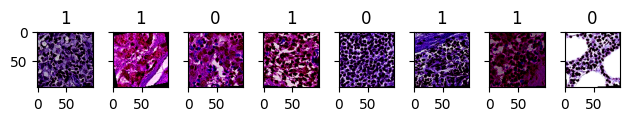

In [23]:
images, labels = next(iter(train_dataloader)) # get first training batch
images = images.numpy()
labels = labels.numpy()
print(f"images is of shape {images.shape}, while labels is of shape {labels.shape}.")

fig, ax = plt.subplots(1,8, sharey=True)
for i in range(len(labels)):
    ax[i].imshow(np.transpose(images[i, :, :, :], (1, 2, 0)))
    ax[i].title.set_text(int(labels[i]))
plt.tight_layout()
plt.show()

### Validation data import with pre-processing pipeline
The following transformations and augmentations are applied to the validation set:
- resizes images to `96`x`96` pixels
- converts the image datatype to a PyTorch tensor
- normalize the pixel values within all color channels to have a mean of `0.5` and a standard deviation of `0.5`

The dataset is then loaded with this pipeline, and a DataLoader is created for efficient loading in batches (no shuffle).

In [24]:
val_test_transform = transforms.Compose([
    transforms.Resize((96,96)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
val_dataset = PCamDataset(csv_file="data/validation_labels.csv", transform=val_test_transform)

val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Test data import with pre-processing pipeline
The test dataset is loaded with the validation pipeline, and a DataLoader is created for efficient loading in batches (no shuffle).

In [26]:
test_dataset = PCamDataset(csv_file="data/test_labels.csv", transform=val_test_transform)

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## CNN Training and Evaluation

### Create CNN
A CNN with 3 convolution layers (with maxpooling layers in between), and two fully connected layers is created. The ReLU activation function is used, and the output is given by a sigmoid. Kernel sizes of 3x3 are used in each convolution layers with padding 1, while max pooling layers use a filter size of 2x2. 

In [27]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(18432, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)).squeeze(1)
        
        return x

In [28]:
# instantiate the model
cnn_model = SimpleCNN()

In [29]:
# set the CNN hardware device to GPU/CPU, and move the model to the available device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The model is moved to {device}.")
cnn_model.to(device)

The model is moved to cpu.


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18432, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
)

In [30]:
# initialize the loss function and optimizer for training
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.0005)

### Train CNN
The CNN is now trained on the training set over 5 epochs, while tracking both the training and validation loss. The losses per epoch are reported.

In [31]:
# keep track of losses per epoch
train_losses = []
val_losses = []

num_epochs = 5 
for epoch in range(num_epochs):
    # loss per epoch
    total_train_loss = 0
    total_val_loss = 0

    # training
    cnn_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()               # set gradients to 0
        outputs = cnn_model(images)         # forward pass
        loss = criterion(outputs, labels)   # calculate loss
        loss.backward()                     # backward pass
        optimizer.step()                    # update weights and biases

        total_train_loss += loss.item()     # update total loss

    # validation
    cnn_model.eval()
    for images, labels in val_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        total_val_loss += loss.item()
    
    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)

    
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss: {total_train_loss/len(train_dataloader):.4f} // Validation Loss: {total_val_loss/len(val_dataloader):.4f}")



Epoch 1/5: Training Loss: 0.6313 // Validation Loss: 0.5079
Epoch 2/5: Training Loss: 0.5374 // Validation Loss: 0.5396
Epoch 3/5: Training Loss: 0.5232 // Validation Loss: 0.4833
Epoch 4/5: Training Loss: 0.5009 // Validation Loss: 0.5424
Epoch 5/5: Training Loss: 0.4852 // Validation Loss: 0.4659


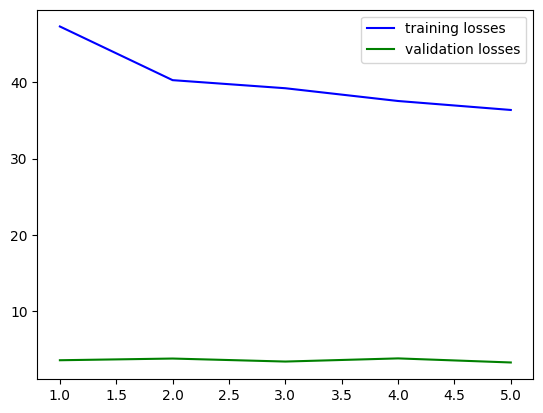

In [32]:
# visualize training and validation losses during training
x = [1,2,3,4,5]
plt.plot(x, train_losses, "b")
plt.plot(x, val_losses, "g")
plt.legend(["training losses", "validation losses"])
plt.show()

### Evaluate CNN
Now the trained model can be used to generate predictions on the test set images, and compared to the test set labels for final evaluation. 

In [33]:
test_pred_probs = []
test_pred_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn_model(images)

        test_pred_probs.extend(outputs.cpu().numpy()) # save outputs as probabilities

        pred_labels = torch.round(outputs) 
        test_pred_labels.extend(pred_labels.cpu().numpy()) # save outputs as labels

test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)

Generate a classification report:

In [34]:
test_true_labels = []

# get labels from the test dataset
for images, labels in test_dataloader:
    test_true_labels.extend(labels.numpy())

pcam_classes = ["Normal", "Tumour"]

report = classification_report(y_true=test_true_labels, y_pred=test_pred_labels, target_names=pcam_classes)
print("Classification report: \n", report)

Classification report: 
               precision    recall  f1-score   support

      Normal       0.77      0.89      0.82        97
      Tumour       0.88      0.75      0.81       103

    accuracy                           0.81       200
   macro avg       0.82      0.82      0.81       200
weighted avg       0.82      0.81      0.81       200

